# TF-IDF原理以及利用其进行特征筛选 

## 1.使用gensim提取文本的tfidf特征 

In [2]:
corpus = [
    'this is the first document',
    'this is the second second document',
    'and the third one',
    'is this the first document'
]
word_list = []
for i in range(len(corpus)):
    word_list.append(corpus[i].split(' '))
print(word_list)

[['this', 'is', 'the', 'first', 'document'], ['this', 'is', 'the', 'second', 'second', 'document'], ['and', 'the', 'third', 'one'], ['is', 'this', 'the', 'first', 'document']]


In [6]:
from gensim import corpora
# 赋给语料库中每个词(不重复的词)一个整数id
dictionary = corpora.Dictionary(word_list)
new_corpus = [dictionary.doc2bow(text) for text in word_list]
print(dictionary)
print(new_corpus)


Dictionary(9 unique tokens: ['document', 'first', 'is', 'the', 'this']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)], [(0, 1), (2, 1), (3, 1), (4, 1), (5, 2)], [(3, 1), (6, 1), (7, 1), (8, 1)], [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [7]:
print(dictionary.token2id)

{'document': 0, 'first': 1, 'is': 2, 'the': 3, 'this': 4, 'second': 5, 'and': 6, 'one': 7, 'third': 8}


In [8]:
# 训练模型并保存
from gensim import models
tfidf = models.TfidfModel(new_corpus)
tfidf.save("my_model.tfidf")

# 载入模型
tfidf = models.TfidfModel.load("my_model.tfidf")

# 使用这个训练好的模型得到单词的tfidf值
tfidf_vec = []
for i in range(len(corpus)):
    string = corpus[i]
    string_bow = dictionary.doc2bow(string.lower().split())
    string_tfidf = tfidf[string_bow]
    tfidf_vec.append(string_tfidf)
print(tfidf_vec)


[[(0, 0.33699829595119235), (1, 0.8119707171924228), (2, 0.33699829595119235), (4, 0.33699829595119235)], [(0, 0.10212329019650272), (2, 0.10212329019650272), (4, 0.10212329019650272), (5, 0.9842319344536239)], [(6, 0.5773502691896258), (7, 0.5773502691896258), (8, 0.5773502691896258)], [(0, 0.33699829595119235), (1, 0.8119707171924228), (2, 0.33699829595119235), (4, 0.33699829595119235)]]


### gensim训练出来的tf-idf值左边是词的id，右边是词的tfidf值
### gensim有自动去除停用词的功能，比如the
### gensim会自动去除单个字母，比如i
### gensim会去除没有被训练到的词，比如name
### 所以通过gensim并不能计算每个单词的tfidf值 

## 2.使用sklearn提取文本tfidf特征 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer()
tfidf_matrix = tfidf_vec.fit_transform(corpus)
# 得到语料库所有不重复的词
print(tfidf_vec.get_feature_names())
# 得到每个单词对应的id值
print(tfidf_vec.vocabulary_)
# 得到每个句子所对应的向量
# 向量里数字的顺序是按照词语的id顺序来的
print(tfidf_matrix.toarray())

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
{'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}
[[0.         0.43877674 0.54197657 0.43877674 0.         0.
  0.35872874 0.         0.43877674]
 [0.         0.27230147 0.         0.27230147 0.         0.85322574
  0.22262429 0.         0.27230147]
 [0.55280532 0.         0.         0.         0.55280532 0.
  0.28847675 0.55280532 0.        ]
 [0.         0.43877674 0.54197657 0.43877674 0.         0.
  0.35872874 0.         0.43877674]]


## 3.python提取文本的tfidf特征 

In [10]:
word_list = []
for i in range(len(corpus)):
    word_list.append(corpus[i].split(' '))
print(word_list)

[['this', 'is', 'the', 'first', 'document'], ['this', 'is', 'the', 'second', 'second', 'document'], ['and', 'the', 'third', 'one'], ['is', 'this', 'the', 'first', 'document']]


In [12]:
from collections import Counter
countlist = []
for i in range(len(word_list)):
    count = Counter(word_list[i])
    countlist.append(count)
countlist

[Counter({'document': 1, 'first': 1, 'is': 1, 'the': 1, 'this': 1}),
 Counter({'document': 1, 'is': 1, 'second': 2, 'the': 1, 'this': 1}),
 Counter({'and': 1, 'one': 1, 'the': 1, 'third': 1}),
 Counter({'document': 1, 'first': 1, 'is': 1, 'the': 1, 'this': 1})]

In [13]:
def tf(word, count):
    return count[word] / sum(count.values())
# 统计的是含有该单词的句子数
def n_containing(word, count_list):
    return sum(1 for count in count_list if word in count)
# len(count_list)是指句子的总数，n_containing(word, count_list)是指含有该单词的句子的总数，加1是为了防止分母为0
def idf(word, count_list):
    return math.log(len(count_list) / (1 + n_containing(word, count_list)))
# 将tf和idf相乘
def tfidf(word, count, count_list):
    return tf(word, count) * idf(word, count_list)

In [14]:
import math
for i, count in enumerate(countlist):
    print("Top words in document {}".format(i + 1))
    scores = {word: tfidf(word, count, countlist) for word in count}
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))


Top words in document 1
	Word: first, TF-IDF: 0.05754
	Word: this, TF-IDF: 0.0
	Word: is, TF-IDF: 0.0
	Word: document, TF-IDF: 0.0
	Word: the, TF-IDF: -0.04463
Top words in document 2
	Word: second, TF-IDF: 0.23105
	Word: this, TF-IDF: 0.0
	Word: is, TF-IDF: 0.0
	Word: document, TF-IDF: 0.0
	Word: the, TF-IDF: -0.03719
Top words in document 3
	Word: and, TF-IDF: 0.17329
	Word: third, TF-IDF: 0.17329
	Word: one, TF-IDF: 0.17329
	Word: the, TF-IDF: -0.05579
Top words in document 4
	Word: first, TF-IDF: 0.05754
	Word: is, TF-IDF: 0.0
	Word: this, TF-IDF: 0.0
	Word: document, TF-IDF: 0.0
	Word: the, TF-IDF: -0.04463


## 参考资料：https://www.jianshu.com/p/f3b92124cd2b 

# 互信息

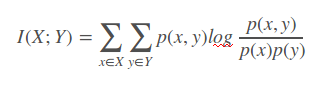

In [17]:
from IPython.display import Image
Image(filename='C:/Users/KAI/im.png')

## 互信息，Mutual Information，缩写为MI，表示两个变量X与Y是否有关系，以及关系的强弱。 

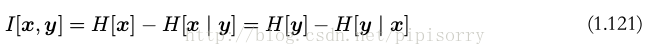

In [18]:
from IPython.display import Image
Image(filename='C:/Users/KAI/shang.png')

## 使用概率的加和规则和乘积规则,我们看到互信息和条件熵之间的关系如上图。
## Y的熵指的是衡量的是Y的不确定度，Y分布得越离散，H(Y)的值越高，H(Y|X)则表示在已知X的情况下，Y的不确定度，所以，根据互信息公式的变形：可以看出，I(X,Y)可以解释为由X引入而使Y的不确定度减小的量，这个减小的量为H(Y|X)，所以，如果X,Y关系越密切，I(X,Y)就越大